# Programming Exercise 3:Multi-class Classification and Neural Networks

## Introduction
In this exercise, you will implement one-vs-all logistic regression and neural
networks to recognize hand-written digits. Before starting the programming
exercise, we strongly recommend watching the video lectures and completing
the review questions for the associated topics.

## 1.Multi-class Classification
For this exercise, you will use logistic regression and neural networks to
recognize handwritten digits (from 0 to 9). Automated handwritten digit
recognition is widely used today - from recognizing zip codes (postal codes)
on mail envelopes to recognizing amounts written on bank checks. This
exercise will show you how the methods you’ve learned can be used for this
classification task.
In the first part of the exercise, you will extend your previous implemen-
tion of logistic regression and apply it to one-vs-all classification.

### 1.1 Dataset
You are given a data set in ex3data1.mat that contains 5000 training exam-
ples of handwritten digits. 2 The .mat format means that that the data has
been saved in a native Octave/MATLAB matrix format, instead of a text
(ASCII) format like a csv-file.

There are 5000 training examples in ex3data1.mat, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional
vector. Each of these training examples becomes a single row in our data
matrix X. This gives us a 5000 by 400 matrix X where every row is a training
example for a handwritten digit image.

he second part of the training set is a 5000-dimensional vector y that
contains labels for the training set. To make things more compatible with
Octave/MATLAB indexing, where there is no zero index, we have mapped
the digit zero to the value ten. Therefore, a “0” digit is labeled as “10”, while
the digits “1” to “9” are labeled as “1” to “9” in their natural order.

In [22]:
import scipy.io as scio #use it to load the .mat in python
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib
from scipy.optimize import minimize

In [23]:
dataFile='ex3data1.mat'
data=scio.loadmat(dataFile) #the tpye of return is dict
X=data['X'] #return the value of key 'X'
y=data['y'] #return the value of key 'y'
m=X.shape[0]
n=X.shape[1]

### 1.2 Visualizing the data
You will begin by visualizing a subset of the training set. In Part 1 of ex3.m,
the code randomly selects selects 100 rows from X and passes those rows
to the displayData function. This function maps each row to a 20 pixel by
20 pixel grayscale image and displays the images together.

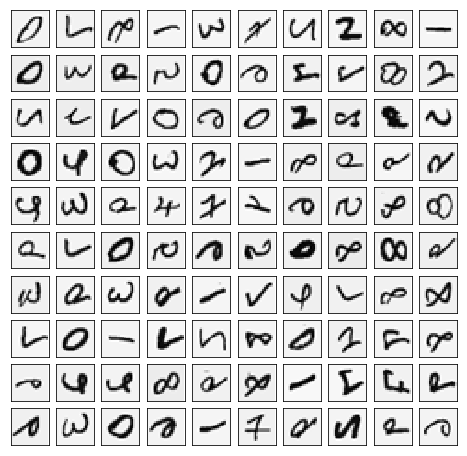

In [24]:
def plot_100_image(X):
    size=int(np.sqrt(X.shape[1]))
    #从5000中随机选取100个数，并整形，然后显示出来
    sample_idx=np.random.choice(np.arange(X.shape[0]),100)    #从5000随机选100个数
    sample_images=X[sample_idx,:]
    fig,ax_array=plt.subplots(nrows=10,ncols=10,sharex=True,sharey=True,figsize=(8,8))
    for r in range(10):
        for c in range(10):
            ax_array[r,c].matshow(sample_images[r*10+c].reshape((size,size)),\
                                  cmap=matplotlib.cm.binary)
            
            plt.xticks(np.array([]))
            plt.yticks(np.array([])) 
plot_100_image(X)
plt.show()

In [7]:
X=np.hstack((np.ones((m,1)),X))
#the index starts from 1 to suit Matlab,but in python,the index starts
#from 0,so I do the following
for i in range(m):
    if y[i]==10:y[i]=0

### 1.3 Vectorizing Logistic Regression
You will be using multiple one-vs-all logistic regression models to build a
multi-class classifier. Since there are 10 classes, you will need to train 10
separate logistic regression classifiers. To make this training efficient, it is
important to ensure that your code is well vectorized. In this section, you
will implement a vectorized version of logistic regression that does not employ
any for loops. You can use your code in the last exercise as a starting point
for this exercise.

In [8]:
#============ Part 2a: Vectorize Logistic Regression ============
#  In this part of the exercise, you will reuse your logistic regression
#  code from the last exercise. You task here is to make sure that your
#  regularized logistic regression implementation is vectorized. After
#  that, you will implement one-vs-all classification for the handwritten
#  digit dataset.

In [11]:
#these following functions have already been writen in my previous exercises
#so there will be no explanitions
def sigmoid(z):
    res=1/(1+np.exp(-z))
    return res
def h(x):
    res=sigmoid(x)
    return res
def costfunction(theta,X,y):
    m=X.shape[0]
    J=(1/m)*np.sum(-y*np.log(h(np.dot(X,theta)))-\
                   (1-y)*np.log(1-h(np.dot(X,theta))))
    return J
def gradient_descent(theta,X,y,alpha,iterations):
    m=X.shape[0]
    for i in range(iterations):
        theta=theta-(alpha/m)*np.dot(X.T,h(np.dot(X,theta))-y)
    return theta
def costfunction_reg(theta,X,y,lambd):
    m=X.shape[0]
    theta=theta.reshape((theta.shape[0],1))
    theta0,theta_penalize=np.vsplit(theta,(1,))
    X_0,X_penalize=np.hsplit(X,(1,))
    #compute J
    J=(1/m)*np.sum(-y*np.log(h(np.dot(X,theta)))\
                   -(1-y)*np.log(1-h(np.dot(X,theta))),axis=0)\
    +(lambd/(2*m))*np.sum(theta_penalize**2,axis=0)
    #compute gradient
    gradient_0=(1/m)*np.dot(X_0.T,h(np.dot(X,theta))-y)
    gradient_penalize=(1/m)*np.dot(X_penalize.T,h(np.dot(X,theta))-y)+(lambd/m)*theta_penalize
    gradient=np.vstack((gradient_0,gradient_penalize))
    return J,gradient.ravel()

In [13]:
#test case for lrCostFunction(logistic regression cost function)
theta_t=np.array(([[-2],[-1],[1],[2]]))
X_t=np.hstack((np.ones((5,1)),np.arange(1,16).reshape(5,3,order='F')/10))
y_t=np.array(([[1],[0],[1],[0],[1]]))
lambda_t=3
J_t,gradient_t=costfunction_reg(theta_t,X_t,y_t,lambda_t)
gradient_t=gradient_t.reshape((gradient_t.shape[0],1))
print('testing lrCostFunction with regularization',J_t)
print('Expected cost:2.534819')
print('Gradients:')
print(gradient_t)
print('Expected gradients:')
print(' 0.146561\n -0.548558\n 0.724722\n 1.398003\n')

testing lrCostFunction with regularization [ 2.5348194]
Expected cost:2.534819
Gradients:
[[ 0.14656137]
 [-0.54855841]
 [ 0.72472227]
 [ 1.39800296]]
Expected gradients:
 0.146561
 -0.548558
 0.724722
 1.398003



### 1.4 One-vs-all Classification
In this part of the exercise, you will implement one-vs-all classification by
training multiple regularized logistic regression classifiers, one for each of
the K classes in our dataset (Figure 1). In the handwritten digits dataset,
K = 10, but your code should work for any value of K.

In particular, your code should return all the classifier parameters
in a matrix Θ ∈ R K×(N +1) , where each row of Θ corresponds to the learned
logistic regression parameters for one class. You can do this with a “for”-loop
from 1 to K, training each classifier independently.

In [20]:
#define the one-vs-all function
def oneVsAll(K,X,y,lambd):
    m,n=X.shape[0],X.shape[1]-1
    initial_theta=np.zeros((n+1,K))
    J=np.zeros((K,))
    for i in range(K):
        y_new=np.zeros((m,1))
        for j in range(m):
            y_new[j][0]=(y[j][0]==i)
        optimizeResult=minimize(fun=costfunction_reg,x0=initial_theta[:,i],args=(X,y_new,lambd),method='BFGS',\
                               jac=True,options={'maxiter':400})
        initial_theta[:,i]=optimizeResult.x
        J[i]=optimizeResult.fun
    return initial_theta,J
lambd=0.1
theta,J=oneVsAll(10,X,y,lambd)
print(theta)
print(J)

[[ -8.04970534e+00  -3.05742380e+00  -3.72306025e+00 ...,  -2.28333704e+00
   -9.10870077e+00  -5.62676482e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]
 ..., 
 [ -1.50925542e-04   6.43895395e-03   1.97631280e-02 ...,  -5.75742641e-03
   -4.79930460e-04  -1.07119358e-02]
 [  5.41842668e-06   2.56062762e-08  -2.22308783e-03 ...,   6.76227062e-04
    5.07399306e-05   8.15304395e-04]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00 ...,   0.00000000e+00
    0.00000000e+00   0.00000000e+00]]
[ 0.00858334  0.01312837  0.05082235  0.05761784  0.03307485  0.05447489
  0.01826458  0.03065318  0.07847322  0.0712046 ]


In [21]:
h_predict=h(np.dot(X,theta))
y_predict=np.zeros((m,1))
for i in range(m):
    y_predict[i][0]=np.argmax(h_predict[i])
num=0
for i in range(m):
    if y_predict[i][0]==y[i][0]:
        num+=1
accurary=num/m
print("the accurary is",accurary*100,"%")

the accurary is 96.48 %


## 2 Neural Networks
In the previous part of this exercise, you implemented multi-class logistic re-
gression to recognize handwritten digits. However, logistic regression cannot
form more complex hypotheses as it is only a linear classifier. 3
In this part of the exercise, you will implement a neural network to rec-
ognize handwritten digits using the same training set as before. The neural
network will be able to represent complex models that form non-linear hy-
potheses. For this week, you will be using parameters from a neural network
that we have already trained. Your goal is to implement the feedforward
propagation algorithm to use our weights for prediction. In next week’s ex-
ercise, you will write the backpropagation algorithm for learning the neural
network parameters.

In [241]:
#load the data and initialize what we need
dataFile='ex3weights.mat'
data=scio.loadmat(dataFile)
Theta1=data['Theta1']
Theta2=data['Theta2']
dataFile='ex3data1.mat'
data=scio.loadmat(dataFile)
y=data['y']
X=data['X']
m,n=X.shape
X=np.vstack((np.ones((1,m)),X.T))

In [242]:
hidden=sigmoid(np.dot(Theta1,X))
hidden=np.vstack((np.ones((1,m)),hidden))
output=sigmoid(np.dot(Theta2,hidden))
output=np.argmax(output,axis=0)
y_predict=np.zeros((m,1))
for i in range(m):
    y_predict[i][0]=output[i]+1
num=0
for i in range(m):
    if y[i][0]!=y_predict[i][0]:
        num+=1
accurary=(m-num)/m
print(accurary*100,'%')

97.52 %
